In [25]:
%reload_ext autoreload
%autoreload 2
import morph_mm.models.transformer as transformer
from morph_mm.models.img_bert import ImgBERT
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

from configs import config_train_imgbert

Matplotlib is building the font cache; this may take a moment.


In [3]:
cfg = config_train_imgbert.get_train_cfg()
cfg

data:
  img_size: 128
  in_channels: 5
  patch_size: 32
model:
  decoder_config:
    mlp_inner_dim: 64
    mlp_num_inner_layers: 1
  encoder_cfg:
    mlp_inner_dim: 64
    model_dim: 32
    num_heads: 4
    num_layers: 3
  mask_ratio: 0.25

In [43]:
x = torch.tensor(np.random.randn(8, 16, 32), dtype=torch.float)
x.shape

torch.Size([8, 16, 32])

In [30]:
tmp = transformer.Transformer(config)
out = tmp(x)
print(out.shape)

torch.Size([8, 16, 32])


In [39]:
x = torch.tensor(np.random.randn(1, 32), dtype=torch.float)
x = x[None, :, :].expand(-1, 5, -1)
x.shape

torch.Size([1, 5, 32])

In [60]:
x = torch.tensor(np.random.rand(1, 5, 128, 128), dtype=torch.float)
tmp = ImgBERT(cfg)
pred, take = tmp({'img':x})
take.shape

torch.Size([1, 4, 32])

In [12]:
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
train_mnist = torchvision.datasets.MNIST(root='/Users/shiveshchaudhary/Documents/projects/mnist',
                                         train=True,
                                         download=True,
                                         transform=image_transform)

In [ ]:
x = train_mnist[1][0]
x = x.repeat(3, 1, 1)

nch = x.shape[0]
ps = 7
nx = x.shape[1]//ps
ny = x.shape[2]//ps
x = x[None, :, :, :]
x = torch.reshape(x, (x.shape[0], x.shape[1], nx, ps, ny, ps))
x = torch.permute(x, (0, 1, 2, 4, 3, 5))
x = torch.reshape(x, (x.shape[0], x.shape[1], nx, ny, -1))
x = torch.reshape(x, (x.shape[0], x.shape[1], -1, x.shape[4]))
x = torch.permute(x, (0, 2, 1, 3))
x = torch.reshape(x, (x.shape[0], x.shape[1], -1))
x.shape

torch.Size([1, 16, 147])

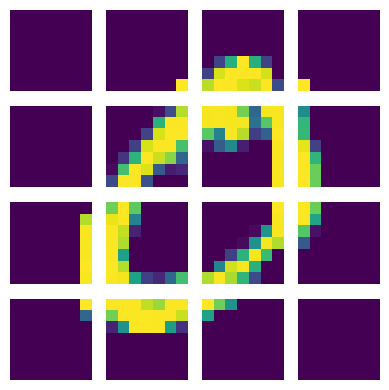

In [55]:
tmp = torch.reshape(x, (x.shape[0], x.shape[1], -1, ps, ps))
fig, ax = plt.subplots(4, 4, figsize=(4, 4))
for i in range(x.shape[2]):
    s_row = i//4
    s_col = i%4
    ax[s_row, s_col].imshow(tmp[0, 0, i])
    ax[s_row, s_col].axis('off')
fig.tight_layout()

In [44]:
x = torch.reshape(x, (x.shape[0], x.shape[1], nx, ny, ps, ps))
x = torch.permute(x, (0, 1, 2, 4, 3, 5))
x = torch.reshape(x, (x.shape[0], x.shape[1], nx*ps, ny*ps))
x.shape

torch.Size([1, 1, 28, 28])

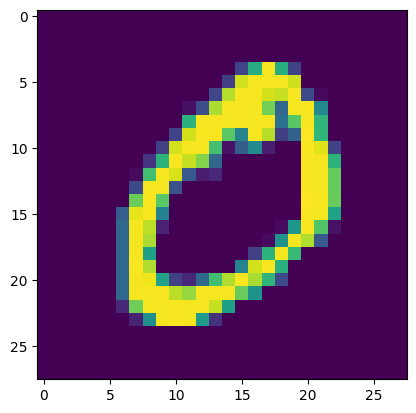

In [45]:
plt.imshow(x[0, 0])